Cell 1: Installation & Setup

In [24]:
# Install Hugging Face transformers and evaluation libraries
!pip install evaluate

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import DataCollatorForSeq2Seq
import evaluate
import nltk
import os
os.environ["WANDB_DISABLED"] = "true"

# Download punkt for sentence splitting
nltk.download("punkt")
nltk.download("punkt_tab")
print("Libraries installed and ready.")

Libraries installed and ready.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Cell 2: Data Loading & Inspection

✅ Loaded 136238 samples.


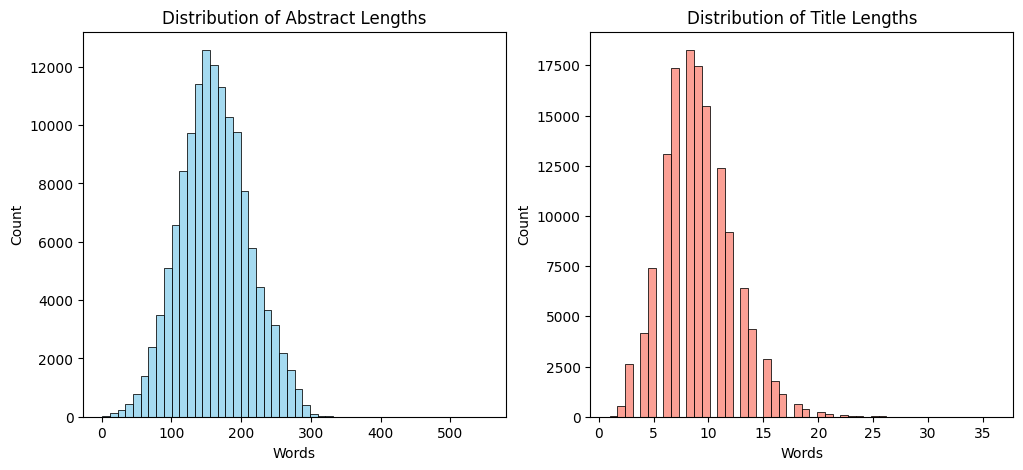

Training on 4500 samples, Validating on 500 samples.


In [25]:
# --- CELL 2: DATA LOADING & EDA ---

# Load the dataset. CHANGE 'arxiv_data.csv' to the exact name of your uploaded file.
filename = 'arXiv_scientific dataset.csv'
try:
    df = pd.read_csv(filename)
    print(f"✅ Loaded {len(df)} samples.")
except FileNotFoundError:
    print("❌ File not found! Please upload the CSV file to Colab files on the left.")

# PREPROCESSING: Drop missing values to avoid errors
df = df.dropna(subset=['summary', 'title'])

# VISUALIZATION
# We analyze the length of abstracts to decide on truncation padding
df['abstract_len'] = df['summary'].apply(lambda x: len(str(x).split()))
df['title_len'] = df['title'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['abstract_len'], bins=50, color='skyblue')
plt.title('Distribution of Abstract Lengths')
plt.xlabel('Words')

plt.subplot(1, 2, 2)
sns.histplot(df['title_len'], bins=50, color='salmon')
plt.title('Distribution of Title Lengths')
plt.xlabel('Words')
plt.show()

# SPLITTING DATA
# We use a smaller subset (e.g., 5000) for faster training in Colab.
# You can increase this number if you have time.
subset_df = df.sample(n=5000, random_state=42)
train_df, val_df = train_test_split(subset_df, test_size=0.1, random_state=42)

print(f"Training on {len(train_df)} samples, Validating on {len(val_df)} samples.")

Cell 3: Model Preparation & Optimization

In [26]:
# --- CELL 3: MODEL & TOKENIZER ---
from datasets import Dataset
import torch

# Convert pandas dataframe to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# Initialize T5 Tokenizer (T5 is an encoder-decoder model) [cite: 90]
model_checkpoint = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def preprocess_function(examples):
    # T5 requires the prefix "summarize: " for this task
    inputs = ["summarize: " + doc for doc in examples["summary"]]
    model_inputs = tokenizer(inputs, max_length=512, truncation=True)

    # Tokenize the targets (titles)
    labels = tokenizer(text_target=examples["title"], max_length=64, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Map the preprocessing function to the data
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_val = val_dataset.map(preprocess_function, batched=True)

# Load the Pre-trained T5 Model
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

# DEFINE OPTIMIZATION TECHNIQUES
# We are applying:
# 1. Weight Decay: Regularization to prevent overfitting.
# 2. Learning Rate Scheduler (Warmup): Improves stability at the start of training.
# 3. FP16 (Mixed Precision): Speeds up training on GPU.

training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    eval_strategy="epoch", # Changed from evaluation_strategy
    learning_rate=3e-4,              # Typical LR for T5
    per_device_train_batch_size=8,   # Adjust based on Colab memory
    per_device_eval_batch_size=8,
    weight_decay=0.01,               # OPTIMIZATION 1: Weight Decay
    save_total_limit=2,
    num_train_epochs=3,              # Number of passes through data
    predict_with_generate=True,
    fp16=torch.cuda.is_available(),  # OPTIMIZATION 2: Mixed Precision
    warmup_steps=500,                # OPTIMIZATION 3: Warmup Steps
    logging_dir='./logs',
    logging_steps=100,
)

print("✅ Model and Training Arguments prepared.")

Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


✅ Model and Training Arguments prepared.


Cell 4: Training & Evaluation

In [27]:
# --- CELL 4: TRAINING & EVALUATION ---

!pip install rouge_score

# Define ROUGE metric function
metric = evaluate.load("rouge")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    # Apply argmax to get the predicted token IDs from logits if predictions are 3D
    # The OverflowError suggests that predictions might be logits instead of token IDs
    if predictions.ndim == 3:
        predictions = np.argmax(predictions, axis=-1)

    # Ensure predictions are integer type for batch_decode
    predictions = predictions.astype(np.int64)

    # Handle NaN values in predictions by replacing them with pad_token_id
    predictions = np.nan_to_num(predictions, nan=tokenizer.pad_token_id).astype(np.int64)

    # Clamp predictions to be within the valid vocabulary range
    min_vocab_id = 0
    max_vocab_id = tokenizer.vocab_size - 1
    predictions = np.clip(predictions, min_vocab_id, max_vocab_id).astype(np.int64)

    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Rouge expects newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    return {k: round(v * 100, 4) for k, v in result.items()}

# Initialize Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# START TRAINING
print("🚀 Starting training... this may take 10-15 minutes.")
trainer.train()

# Save the final model for your submission
trainer.save_model("./final_t5_model")
print("✅ Model saved to ./final_t5_model")

/tmp/ipython-input-3837254755.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


🚀 Starting training... this may take 10-15 minutes.


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,2.453400,2.173289,39.761400,21.022200,35.682500,35.778500
2,2.176200,2.073007,43.054000,23.569300,38.589900,38.642900
3,1.897700,2.064379,42.200000,23.133100,38.026400,38.208500


✅ Model saved to ./final_t5_model


Cell 5: Demo / Inference

In [28]:
# --- CELL 5: INFERENCE DEMO ---

def generate_title(abstract):
    inputs = tokenizer("summarize: " + abstract, return_tensors="pt", max_length=512, truncation=True)
    inputs = {k: v.to(model.device) for k, v in inputs.items()} # Move to GPU

    outputs = model.generate(inputs["input_ids"], max_length=40, num_beams=4, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Pick a random sample from validation set to test
sample = val_df.iloc[0]
print(f"🔹 ABSTRACT:\n{sample['summary'][:400]}...") # Show first 400 chars
print(f"\n🔸 ACTUAL TITLE: {sample['title']}")
print(f"\n🚀 GENERATED TITLE: {generate_title(sample['summary'])}")
!zip -r final_t5_model.zip final_t5_model

🔹 ABSTRACT:
An onboard prediction of dynamic parameters (e.g. Aerodynamic drag, rolling
resistance) enables accurate path planning for EVs. This paper presents
EV-PINN, a Physics-Informed Neural Network approach in predicting instantaneous
battery power and cumulative energy consumption during cruising while
generalizing to the nonlinear dynamics of an EV. Our method learns real-world
parameters such as motor...

🔸 ACTUAL TITLE: EV-PINN: A Physics-Informed Neural Network for Predicting Electric
  Vehicle Dynamics

🚀 GENERATED TITLE: EV-PINN: Physics-Informed Neural Network for Onboard Prediction of Dynamic Parameters
